In [1]:
import glob
import os
import random

import numpy as np
import torch
import torch.nn as nn
from facenet_pytorch import MTCNN
from matplotlib import pyplot as plt
from PIL import Image
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

mtcnn = MTCNN(image_size=224, post_process=False, device=device)

Using device: cuda


In [3]:
DATASET_PATH = "data/DBs/HQf/"

In [4]:
class SiblingsDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(224, 224)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.samples = []

        persons = os.listdir(root_dir)
        for p in persons:
            sub = os.path.join(root_dir, p)
            if not os.path.isdir(sub):
                continue

            imgs = glob.glob(os.path.join(sub, "*.jpg"))
            for img in imgs:
                csv = img.replace(".jpg", ".csv")
                if os.path.exists(csv):
                    self.samples.append((img, csv))

    def __len__(self):
        return len(self.samples)

    def load_landmarks(self, csv_path):
        return np.loadtxt(csv_path, delimiter=",", usecols=(1, 2), skiprows=1)

    def __getitem__(self, idx):
        img_path, csv_path = self.samples[idx]
        landmarks = self.load_landmarks(csv_path)

        img = Image.open(img_path).convert("RGB")
        original_width, original_height = img.size

        boxes, _ = mtcnn.detect(img)

        if boxes is None or len(boxes) == 0:
            face = img
            x1, y1, x2, y2 = 0, 0, original_width, original_height
        else:
            box = boxes[0]
            x1, y1, x2, y2 = box.astype(int)

            face_tensor = mtcnn(img)
            if face_tensor is None:
                face = img
                x1, y1, x2, y2 = 0, 0, original_width, original_height
            else:
                face = Image.fromarray(
                    face_tensor.permute(1, 2, 0).int().numpy().astype(np.uint8)
                )

        translated_landmarks = np.copy(landmarks)
        translated_landmarks[:, 0] -= x1
        translated_landmarks[:, 1] -= y1

        face_width = x2 - x1
        face_height = y2 - y1
        target_width, target_height = self.target_size

        # scaling factor is (Target size) / (Detected face size)
        scale_x = target_width / face_width
        scale_y = target_height / face_height

        scaled_landmarks = translated_landmarks.astype(float)
        scaled_landmarks[:, 0] *= scale_x
        scaled_landmarks[:, 1] *= scale_y

        if self.transform:
            face = self.transform(face)

        scaled_landmarks_tensor = torch.tensor(
            scaled_landmarks.flatten(), dtype=torch.float32
        )

        return face, scaled_landmarks_tensor

In [5]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [6]:
dataset = SiblingsDataset(DATASET_PATH, transform=transform)
print("Dataset size:", len(dataset))

total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_len, val_len, test_len]
)

Dataset size: 180


In [7]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(
    f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}"
)

Train: 125, Val: 36, Test: 19


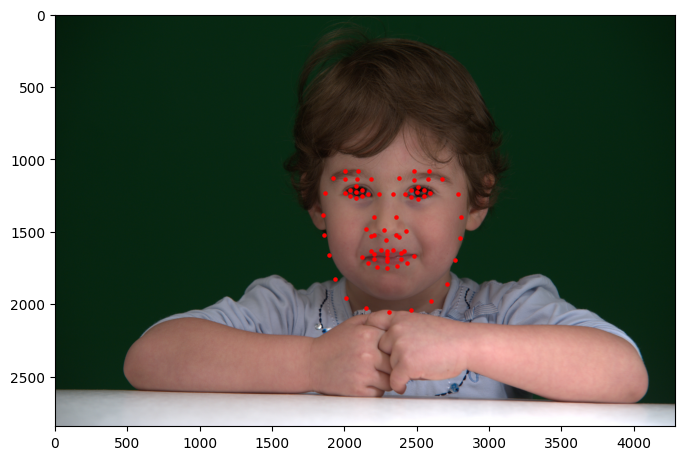

In [8]:
file_name = "data/DBs/HQf/267/_DSC3077"
# file_name = "data/DBs/HQf/261/261"
# file_name = "data/DBs/HQf/259/259"
# file_name = "data/DBs/HQf/220/_DSC2248"
img = Image.open(f"{file_name}.jpg").convert("RGB")
landmarks = dataset.load_landmarks(f"{file_name}.csv")
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.scatter(landmarks[:, 0], landmarks[:, 1], c="r", s=5)
plt.show()

Number of landmark outputs: 76


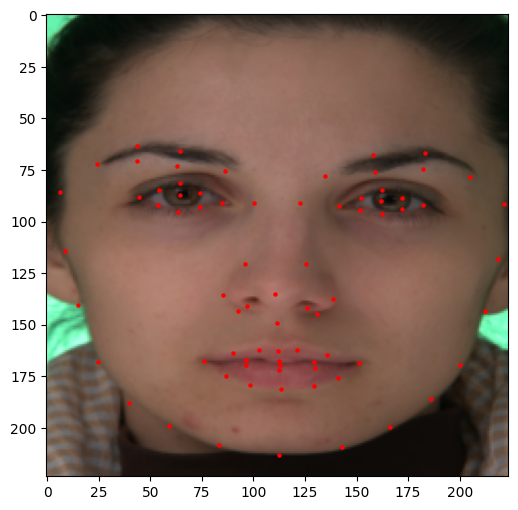

In [9]:
sample_img, sample_landmarks = dataset[0]
num_outputs = sample_landmarks.shape[0]
print("Number of landmark outputs:", num_outputs // 2)

sample_img_np = sample_img.permute(1, 2, 0).numpy()  # shape (H, W, C)
sample_img_np = np.clip(sample_img_np, 0, 1)

# reshape landmarks to (76, 2)
sample_landmarks = sample_landmarks.numpy().reshape(-1, 2)

plt.figure(figsize=(6, 6))
plt.imshow(sample_img_np)
plt.scatter(sample_landmarks[:, 0], sample_landmarks[:, 1], c="r", s=5)
plt.show()

In [10]:
class Network(nn.Module):
    def __init__(self, num_classes=152):
        super().__init__()
        self.model = models.resnet18()
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


network = Network(num_classes=num_outputs).to(device)

In [11]:
criterion = nn.MSELoss()
optimizer = AdamW(network.parameters(), lr=0.01)

In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    network.train()
    total_loss = 0.0

    for imgs, targets in train_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = network(imgs)

        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # validation
    network.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = imgs.to(device)
            targets = targets.to(device)

            preds = network(imgs)
            val_loss += criterion(preds, targets).item()

    avg_val_loss = val_loss / len(val_loader)
    print(
        f"Epoch {epoch + 1}/{num_epochs}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}"
    )

Epoch 1/10: Train Loss=12080.8158, Val Loss=5944.3037
Epoch 2/10: Train Loss=3013.3089, Val Loss=1134.5982
Epoch 3/10: Train Loss=594.2039, Val Loss=347.6453
Epoch 4/10: Train Loss=183.0311, Val Loss=454.9790
Epoch 5/10: Train Loss=117.1529, Val Loss=680.7889
Epoch 6/10: Train Loss=66.5541, Val Loss=330.4126
Epoch 7/10: Train Loss=56.3938, Val Loss=177.2306
Epoch 8/10: Train Loss=45.0247, Val Loss=49.4385
Epoch 9/10: Train Loss=40.2488, Val Loss=36.9903
Epoch 10/10: Train Loss=38.5774, Val Loss=32.5327


In [13]:
network.eval()
test_loss = 0.0

with torch.no_grad():
    for imgs, targets in test_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        preds = network(imgs)
        loss = criterion(preds, targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Average Test Loss: {avg_test_loss:.4f}")

Average Test Loss: 43.7934


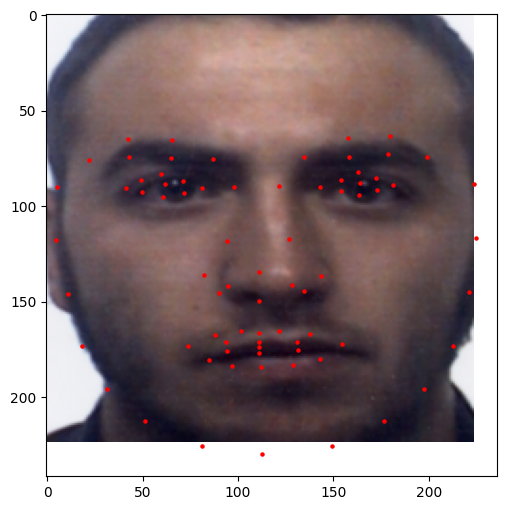

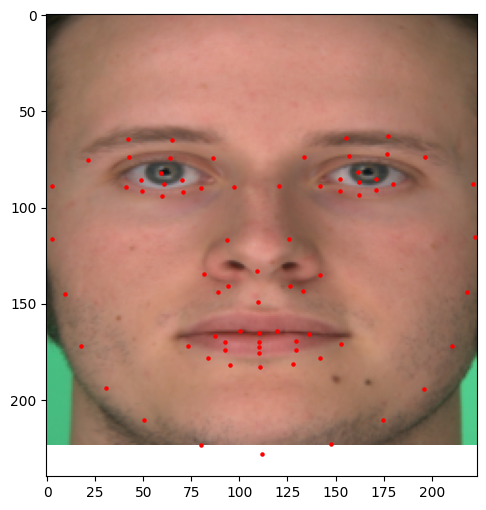

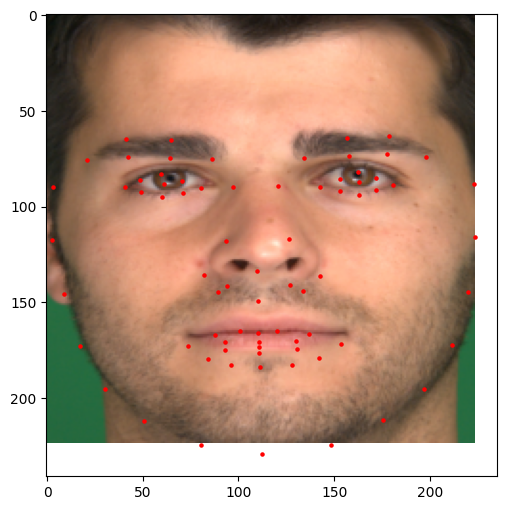

In [14]:
def show_predicted_landmarks_from_tensor(img_tensor, pred_landmarks):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    landmarks = pred_landmarks.reshape(-1, 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c="r", s=5)
    plt.show()


# Pick 3 random samples from test set
sample_indices = random.sample(range(len(test_dataset)), 3)

for idx in sample_indices:
    img_tensor, target_landmarks = test_dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_landmarks = network(input_tensor).cpu().numpy()

    show_predicted_landmarks_from_tensor(img_tensor, pred_landmarks)

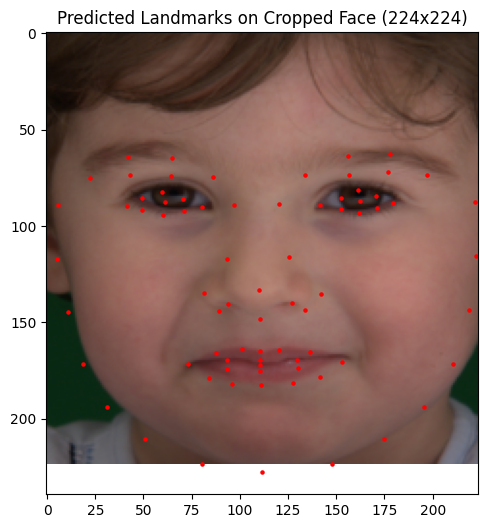

In [15]:
def show_predicted_face_landmarks(img_path):
    img = Image.open(img_path).convert("RGB")

    face_tensor = mtcnn(img)

    if face_tensor is None:
        raise ValueError("No face detected by MTCNN for cropping.")

    face_img = Image.fromarray(
        face_tensor.permute(1, 2, 0).int().numpy().astype(np.uint8)
    )

    face_input = transform(face_img).unsqueeze(0).to(device)

    network.eval()
    with torch.no_grad():
        pred_scaled = network(face_input).cpu().numpy().reshape(-1, 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(face_img)
    plt.scatter(pred_scaled[:, 0], pred_scaled[:, 1], c="r", s=5)
    plt.title("Predicted Landmarks on Cropped Face (224x224)")
    plt.show()


show_predicted_face_landmarks("data/DBs/HQf/267/_DSC3077.jpg")

In [16]:
LEFT_PUPIL = 32
RIGHT_PUPIL = 37
ME17_INDICES = [
    28,  # left eye left corner
    30,  # left eye right corner
    35,  # right eye left corner
    33,  # right eye right corner
    69,  # eyelid top left left eye
    70,  # eyelid top right left eye
    74,  # eyelid top left right eye
    73,  # eyelid top right right eye
    72,  # eyelid bottom left left eye
    71,  # eyelid bottom right left eye
    75,  # eyelid bottom left right eye
    76,  # eyelid bottom right right eye
    49,  # mouth left corner
    55,  # mouth right corner
    52,  # mouth upper lip center
    58,  # mouth lower lip center
    68,  # nose tip
]
ME17_INDICES_ZERO_BASED = [i - 1 for i in ME17_INDICES]

In [17]:
def evaluate(loader, model, device):
    model.eval()

    loss_fn = nn.MSELoss()

    total_loss = 0
    total_me17 = 0
    total_samples = 0

    with torch.no_grad():
        for images, landmarks in loader:
            images = images.to(device)
            landmarks = landmarks.to(device)

            preds = model(images)

            # ---- reshape from (B, 136) -> (B, 68, 2)
            preds = preds.view(preds.size(0), -1, 2)
            landmarks = landmarks.view(landmarks.size(0), -1, 2)

            total_loss += loss_fn(preds, landmarks).item()

            pred17 = preds[:, ME17_INDICES_ZERO_BASED, :]  # (B, 17, 2)
            gt17 = landmarks[:, ME17_INDICES_ZERO_BASED, :]  # (B, 17, 2)

            dist = torch.norm(pred17 - gt17, dim=2).mean(dim=1)

            gt_pupil_dist = torch.norm(
                landmarks[:, LEFT_PUPIL - 1, :] - landmarks[:, RIGHT_PUPIL - 1, :],
                dim=1,
            )

            me17_values = dist / gt_pupil_dist

            total_me17 += me17_values.sum().item()
            total_samples += images.size(0)

    return {
        "Loss": total_loss / total_samples,
        "me17": total_me17 / total_samples,
    }


train_stats = evaluate(train_loader, network, device)
val_stats = evaluate(val_loader, network, device)
test_stats = evaluate(test_loader, network, device)

print("Train:", train_stats)
print("Val:  ", val_stats)
print("Test: ", test_stats)

Train: {'Loss': 2.4174374389648436, 'me17': 0.07153260803222657}
Val:   {'Loss': 2.7110611067877874, 'me17': 0.0688539660639233}
Test:  {'Loss': 4.609830755936472, 'me17': 0.07216640836314152}
